<a href="https://colab.research.google.com/github/BlancoAnna/DL--2025/blob/main/Problems%208%20-%20Autoencoders/P8_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/dkaratzas/DL2024-25/blob/main/Problems%208%20-%20Autoencoders/P8_Autoencoders.ipynb)

# Autoencoders

In this notebook we will explore three different types of autoencoder architectures: Simple MLP Autoencoder, Convolutional Autoencoder and Variational Autoencoder (VAE). We will also see how we can use VAEs to generate new data.

In [41]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
import numpy as np

# Setting up

In [42]:
#If this cell fails you need to change the runtime of your colab notebook to GPU
# Go to Runtime -> Change Runtime Type and select GPU
assert torch.cuda.is_available(), "GPU is not enabled"

#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [43]:
def show_image(img):
    img = img.clamp(0, 1) # Ensure that the range of greyscales is between 0 and 1
    npimg = img.numpy()   # Convert to NumPy
    npimg = np.transpose(npimg, (2, 1, 0))   # Change the order to (W, H, C)
    plt.imshow(npimg)
    plt.show()

In [44]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(
    root="data", train=True, transform=transform, download=True
)

test_dataset = torchvision.datasets.MNIST(
    root="data", train=False, transform=transform, download=True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=2
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False, num_workers=2
)

# Simple Autoencoder

We will define a simple MLP Autoencoder

In [45]:
class AE(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=128),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(in_features=128, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=input_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [46]:
model = AE(input_size=784).to(device)

# create an optimizer object
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# mean-squared error loss
criterion = nn.MSELoss()

Define the training and testing loops

In [47]:
def train(model, loader, optimizer, criterion, reshape=False):
    loss = 0
    model.train()

    for batch_features, _ in loader:
        # load it to the active device
        batch_features = batch_features.to(device)

        # reshape mini-batch data to [N, 784] matrix (turn images into vectors, and subsume channel)
        if reshape:
            batch_features = batch_features.view(-1, 784)

        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()

        # compute reconstructions
        outputs = model(batch_features)

        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features)

        # compute accumulated gradients
        train_loss.backward()

        # perform parameter update based on current gradients
        optimizer.step()

        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()

    # compute the epoch training loss
    loss = loss / len(loader)
    print("epoch : {}/{}, Train loss = {:.6f}".format(epoch + 1, epochs, loss))

def test(model, loader, criterion, reshape=False):
    loss = 0
    model.eval()

    for batch_features, _ in loader:
        batch_features = batch_features.to(device)

        # reshape mini-batch data to [N, 784] matrix (turn images into vectors, and subsume channel)
        if reshape:
            batch_features = batch_features.view(-1, 784)

        with torch.no_grad():
            outputs = model(batch_features)

        # compute training reconstruction loss
        test_loss = criterion(outputs, batch_features)

        # add the mini-batch training loss to epoch loss
        loss += test_loss.item()

    # compute the epoch test loss
    loss = loss / len(loader)

    # display the epoch training loss
    print("epoch : {}/{}, Test loss = {:.6f}".format(epoch + 1, epochs, loss))
    show_image(make_grid(batch_features.detach().cpu().view(-1, 1, 28, 28).transpose(2, 3), nrow=2, normalize = True))
    show_image(make_grid(outputs.detach().cpu().view(-1, 1, 28, 28).transpose(2, 3), nrow=2, normalize = True))

epoch : 1/10, Train loss = 0.048324
epoch : 1/10, Test loss = 0.025273


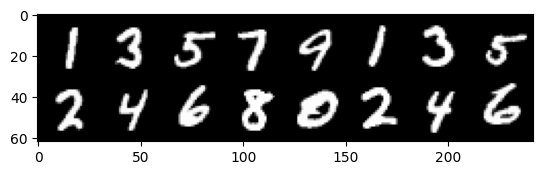

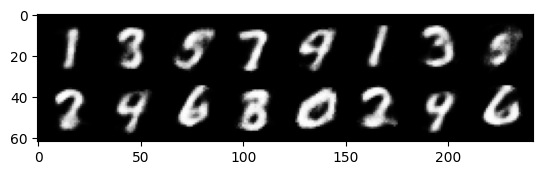

epoch : 2/10, Train loss = 0.020263
epoch : 2/10, Test loss = 0.016035


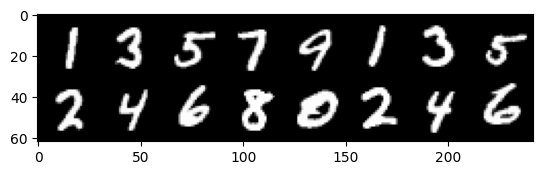

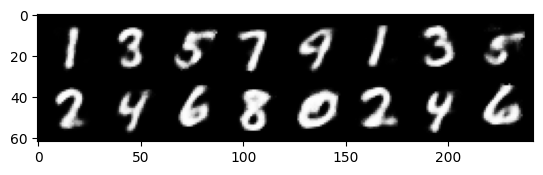

epoch : 3/10, Train loss = 0.014476
epoch : 3/10, Test loss = 0.012423


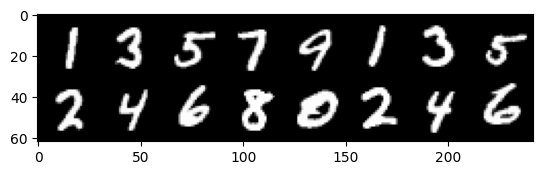

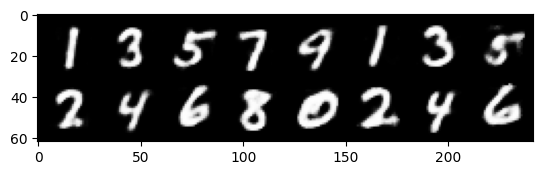

epoch : 4/10, Train loss = 0.011865
epoch : 4/10, Test loss = 0.010534


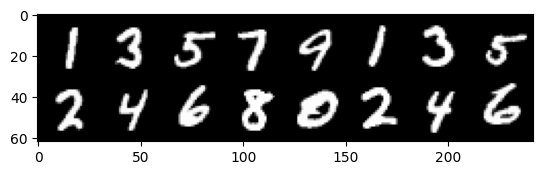

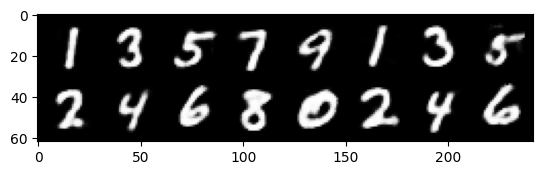

epoch : 5/10, Train loss = 0.010343
epoch : 5/10, Test loss = 0.009384


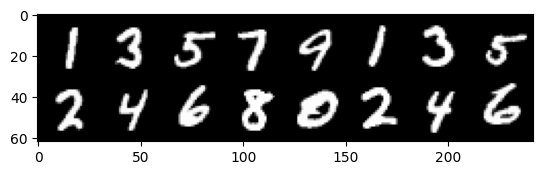

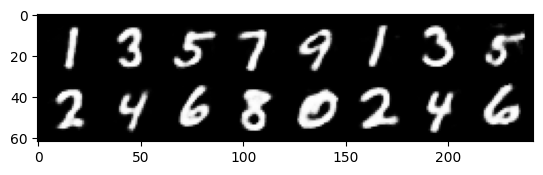

epoch : 6/10, Train loss = 0.009322
epoch : 6/10, Test loss = 0.008605


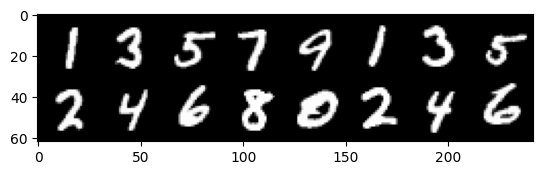

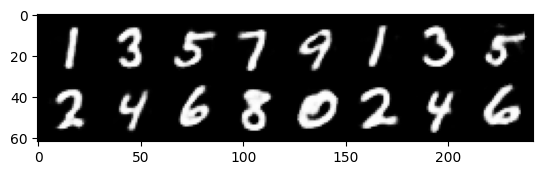

epoch : 7/10, Train loss = 0.008504
epoch : 7/10, Test loss = 0.007799


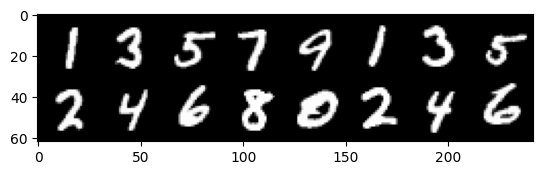

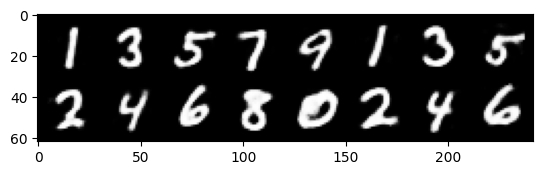

epoch : 8/10, Train loss = 0.007806
epoch : 8/10, Test loss = 0.007267


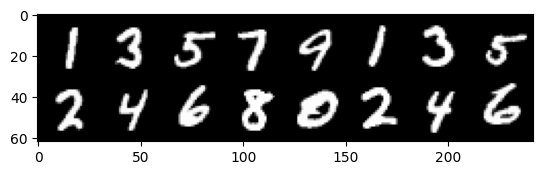

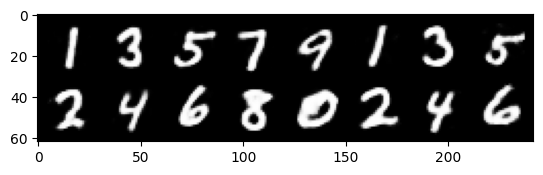

epoch : 9/10, Train loss = 0.007273
epoch : 9/10, Test loss = 0.006746


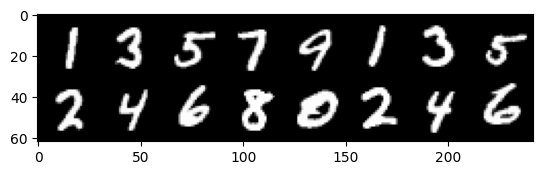

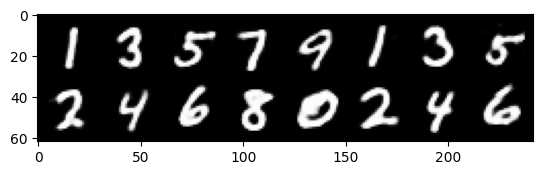

epoch : 10/10, Train loss = 0.006812
epoch : 10/10, Test loss = 0.006401


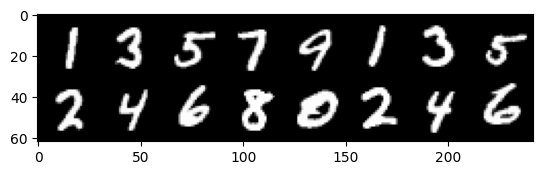

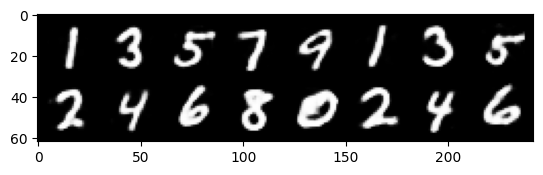

In [48]:
epochs=10
for epoch in range(epochs):
    train(model, train_loader, optimizer, criterion, reshape=True)
    test(model, test_loader, criterion, reshape=True)

# Convolutional Autoencoder

We will now build a convolutional Autoencoder. Below you can find an incomplete implementation of one (only the encoder part)...

In [49]:
class ConvAE(nn.Module):
    def __init__(self):
        super(ConvAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),  # b, 16, 10, 10
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(),
            nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2
        )
        self.decoder = nn.Sequential(

            # THIS PART IS MISSING...

        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

<span style="color:blue">

**Exercise 1**: Build the decoder for the convolutional autoencoder model above and train it using the same functions and hyper-parameters as defined above.

> Hint: Use only deconvolutions (design an non-symmetric architecture) so that you do not have to store indices for the unpooling layers. Have a look at `ConvTranspose2d()` https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html

    
> Hint: Remember that to calculate the new activation map's size while deconvolving you should use: $𝑛^{[𝑙]} =(𝑛^{[𝑙−1]}−1) 𝑠 − 2𝑝 + 𝑓$
    
</span>

In [50]:
# Your code here
class ConvAE(nn.Module):
    def __init__(self):
        super(ConvAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),  # b, 16, 10, 10
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(),
            nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2), #b, 16, 5, 5   :  n[l]=(n[l−1]−1)s−2p+f ----> n[l] = (2-1)2-2*0+3 = 1x2-2x0+3 = 5 ---> 16 x 5 x 5
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1), #b, 8, 15, 15   :   n[l]=(n[l−1]−1)s−2p+f ----> n[l] = (5-1)3-2*1+5 = 4x3-2+5 = 15 ---> 8 x 15 x 15
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1), #b, 1, 28, 28    :   n[l]=(n[l−1]−1)s−2p+f ----> n[l] = (15-1)2-2*1+2 = 14x2-2+2 = 28 ---> 1 x 28 x 28
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

epoch : 1/10, Train loss = 0.075713
epoch : 1/10, Test loss = 0.046814


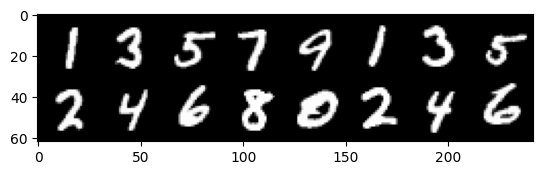

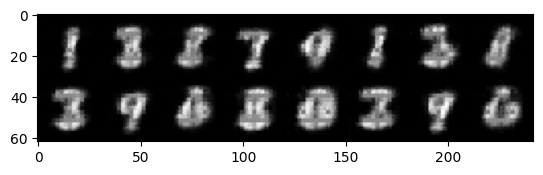

epoch : 2/10, Train loss = 0.041390
epoch : 2/10, Test loss = 0.037318


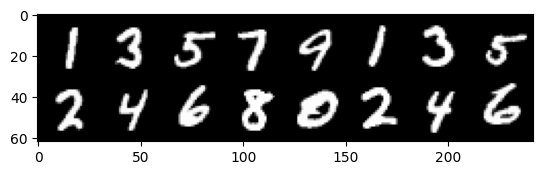

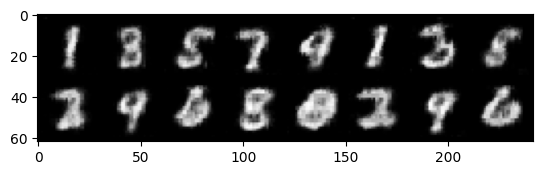

epoch : 3/10, Train loss = 0.036073
epoch : 3/10, Test loss = 0.034416


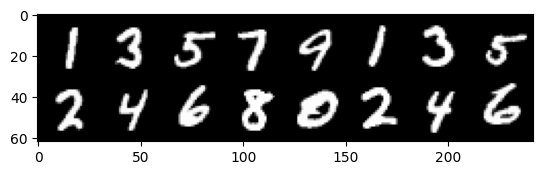

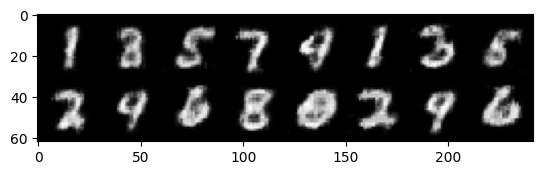

epoch : 4/10, Train loss = 0.033984
epoch : 4/10, Test loss = 0.032856


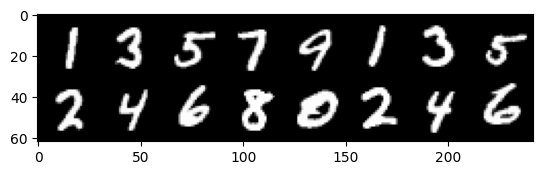

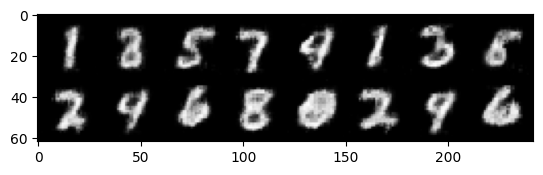

epoch : 5/10, Train loss = 0.032756
epoch : 5/10, Test loss = 0.031814


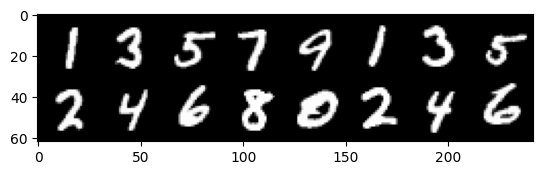

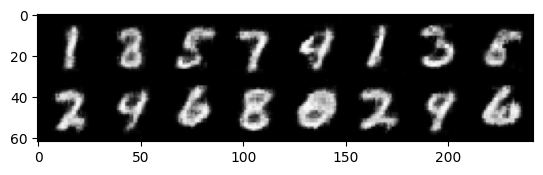

epoch : 6/10, Train loss = 0.031864
epoch : 6/10, Test loss = 0.030933


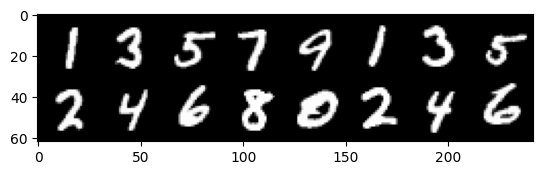

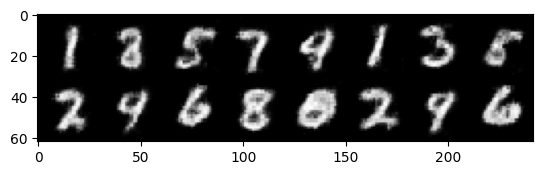

epoch : 7/10, Train loss = 0.031110
epoch : 7/10, Test loss = 0.030212


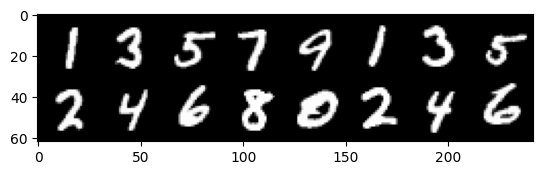

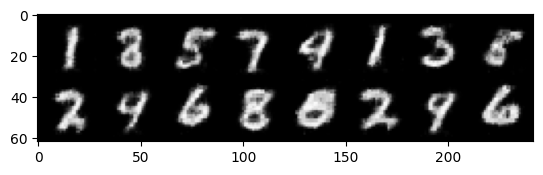

epoch : 8/10, Train loss = 0.030330
epoch : 8/10, Test loss = 0.029558


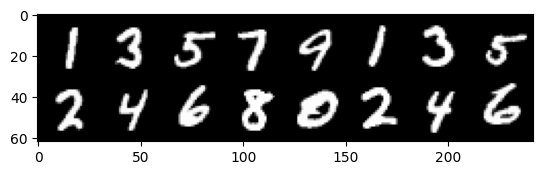

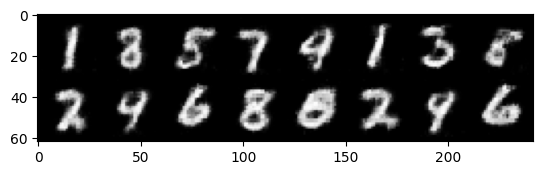

epoch : 9/10, Train loss = 0.029656
epoch : 9/10, Test loss = 0.028776


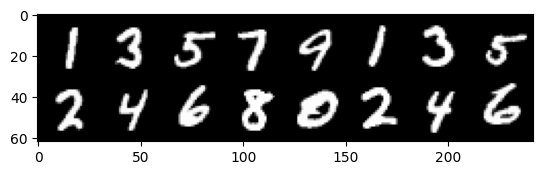

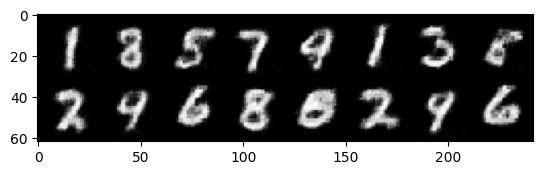

epoch : 10/10, Train loss = 0.029192
epoch : 10/10, Test loss = 0.028463


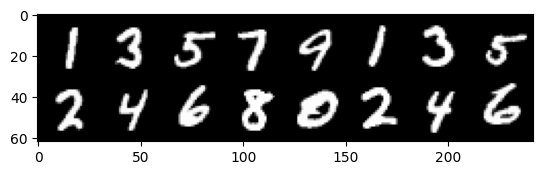

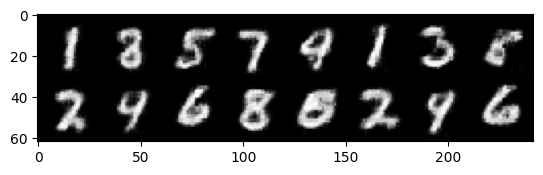

In [51]:
ConvAE = ConvAE().to(device)

# create an optimizer object
optimizer = torch.optim.Adam(ConvAE.parameters(), lr=4e-3)

# mean-squared error loss
criterion = nn.MSELoss()

epochs=10
for epoch in range(epochs):
    train(ConvAE, train_loader, optimizer, criterion, reshape=False)
    test(ConvAE, test_loader, criterion, reshape=False)

<span style="color:blue">

**Exercise 2 (HOMEWORK)**: Rebuild the network, but this time do a symmetric design for the decoder (using unpooling as required) and train it using the same functions and hyper-parameters as defined above.

> Hint: Have a look at `MaxUnpool2d()` https://pytorch.org/docs/stable/generated/torch.nn.MaxUnpool2d.html
    
</span>

In [52]:
# Your Code Here
import torch.nn as nn
from torch.nn.modules.activation import Sigmoid
from torch.nn.modules.conv import ConvTranspose2d
from torch.nn.modules.pooling import MaxUnpool2d

# Define a symmetric Convolutional Autoencoder using nn.Module
class ConvAE_symmetric(nn.Module):
    def __init__(self):
        super(ConvAE_symmetric, self).__init__()

        # Encoder: reduces spatial dimensions and extracts features
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=3, padding=1),  # Output: (16, 10, 10)
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, return_indices=True),  # Output: (16, 5, 5), saving indices for unpooling later
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3, stride=2, padding=1),  # Output: (8, 3, 3)
            nn.ReLU(),
            nn.MaxPool2d(2, stride=1, return_indices=True)  # Output: (8, 2, 2), saving indices again
        )

        # Decoder: mirrors the encoder to reconstruct the input
        self.decoder = nn.Sequential(
            nn.MaxUnpool2d(2, stride=1),  # Reverts the last MaxPool2d using saved indices
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=8, out_channels=16, kernel_size=3, stride=2, padding=1),  # Upsamples
            nn.ReLU(),
            nn.MaxUnpool2d(2, stride=2),  # Reverts the first MaxPool2d using saved indices
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, stride=3, padding=1),  # Final output layer
            nn.Sigmoid()  # Maps output to [0, 1] range
        )

    def forward(self, x):
        indices_list = []  # To store indices from MaxPool2d layers for unpooling

        # Pass through encoder and collect pooling indices
        for layer in self.encoder:
            if isinstance(layer, nn.MaxPool2d):
                x, indices = layer(x)  # Save output and pooling indices
                indices_list.append(indices)
            else:
                x = layer(x)  # Regular layer (Conv or ReLU)

        idx = 1  # To access indices in reverse order during decoding

        # Pass through decoder, using saved indices in unpooling layers
        for layer in self.decoder:
            if isinstance(layer, nn.MaxUnpool2d):
                x = layer(x, indices_list[-idx])  # Use corresponding indices for unpooling
                idx += 1
            else:
                x = layer(x)  # Regular layer (ConvTranspose, ReLU, or Sigmoid)

        return x


epoch : 1/10, Train loss = 0.093069
epoch : 1/10, Test loss = 0.050267


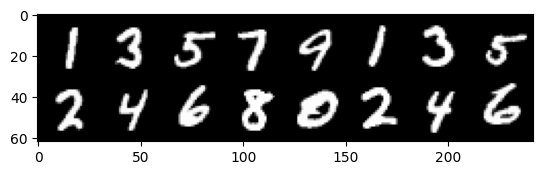

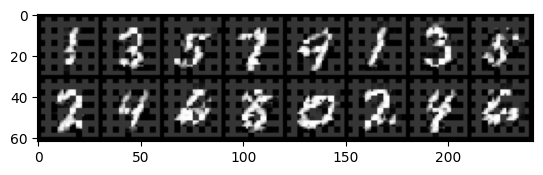

epoch : 2/10, Train loss = 0.039270
epoch : 2/10, Test loss = 0.032027


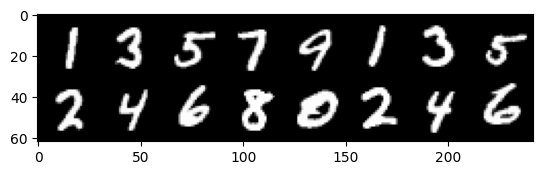

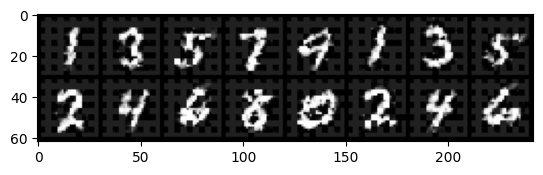

epoch : 3/10, Train loss = 0.029038
epoch : 3/10, Test loss = 0.026906


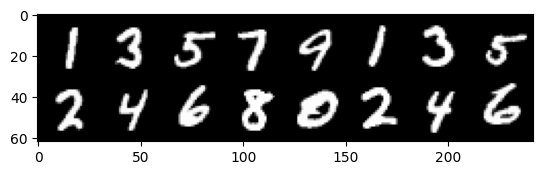

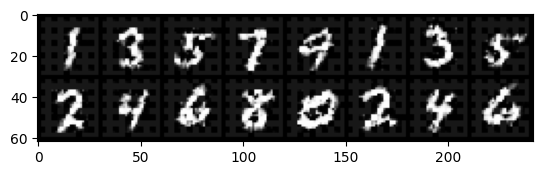

epoch : 4/10, Train loss = 0.025616
epoch : 4/10, Test loss = 0.024738


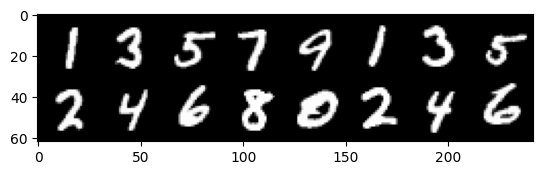

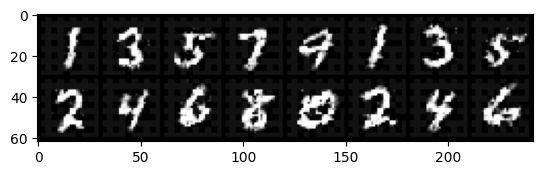

epoch : 5/10, Train loss = 0.024023
epoch : 5/10, Test loss = 0.023624


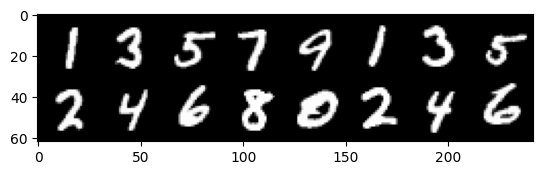

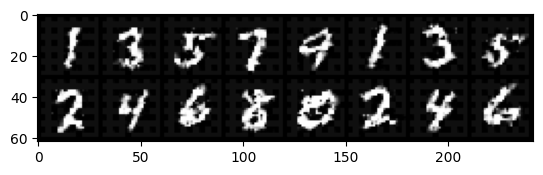

epoch : 6/10, Train loss = 0.023103
epoch : 6/10, Test loss = 0.022776


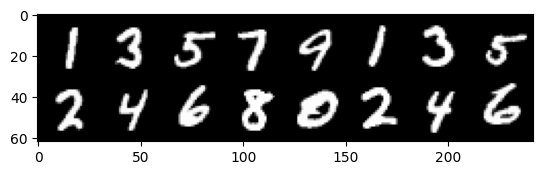

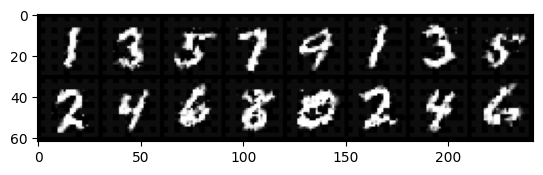

epoch : 7/10, Train loss = 0.022644
epoch : 7/10, Test loss = 0.022695


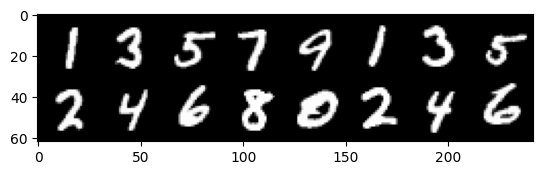

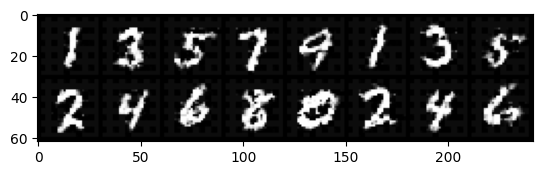

epoch : 8/10, Train loss = 0.022541
epoch : 8/10, Test loss = 0.022589


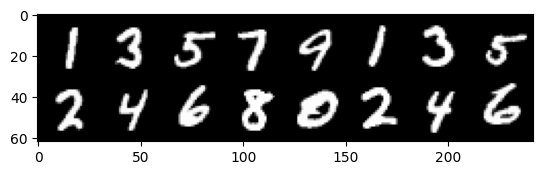

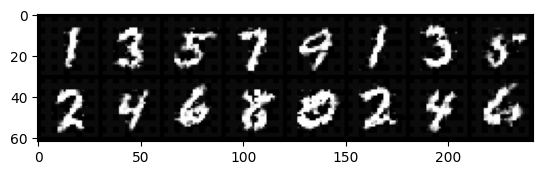

epoch : 9/10, Train loss = 0.022316
epoch : 9/10, Test loss = 0.022250


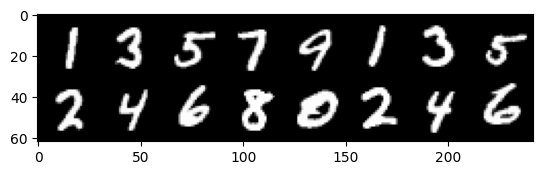

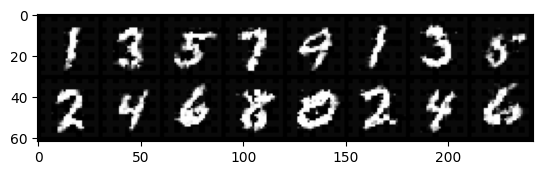

epoch : 10/10, Train loss = 0.022319
epoch : 10/10, Test loss = 0.022494


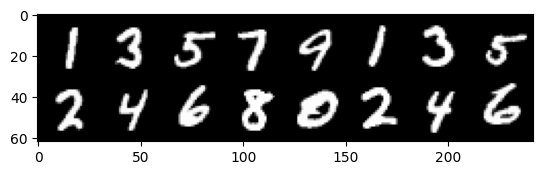

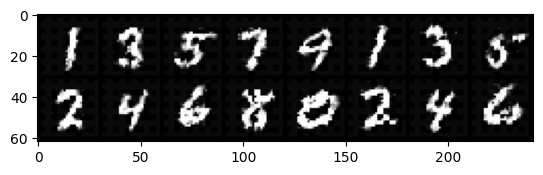

In [53]:
ConvAE_symmetric = ConvAE_symmetric().to(device)

# create an optimizer object
optimizer = torch.optim.Adam(ConvAE_symmetric.parameters(), lr=4e-3)

# mean-squared error loss
criterion = nn.MSELoss()


epochs=10
for epoch in range(epochs):
    train(ConvAE_symmetric, train_loader, optimizer, criterion, reshape=False)
    test(ConvAE_symmetric, test_loader, criterion, reshape=False)

# Variational Autoencoders (VAEs)

Below we define a variational autoencoder. It takes a vector of 784 elements, and maps it into a mean and a `logvar` of size 20.

Note that `logvar` corresponds to $ln(\sigma^2)$.

In [54]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)

        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparametrize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        return mu + eps * std

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar

In the case of the VAE, we need to define our own loss function, as we need to combine the reconstruction loss, with the regularisation term (Gaussian prior for the embedding distribution).

> *NOTE: You will see that we use an MSE loss as a reconstruction loss, instead of the negative log likelihood that we should be using... this actually makes sense. We have designed this model so that the output of the decoder is the image - the pixel values (means) and not distributions over the pixel values (e.g. means and variances of a Gaussian).*

> *This is typical in VAE implementations; the output of the decoder is actually the mean $\mu_{x|z}$ (let's just call it $\mu$) and we usually assumes a unitary covariance. So in that case we have: $log(P(x|z))=-{\frac 1 2}[log(|Σ|)+k log(2\pi)+(x−\mu)^T(x−\mu)]$*

> *This comes from taking the log of the probability density function of a multivariate Gaussian distribution. Now you can see that since the first two terms are constant with respect to $\mu$, the optimization problem is equivalent to maximizing $-{\frac 1 2}(x−\mu)^T(x−\mu)$ which is the just the L2 loss between $x$ and $\mu$. Finally the expectation is just approximated by averaging.*

In [55]:
def loss_function(recon_x, x, mu, logvar):
    """
    recon_x: generating images
    x: origin images
    mu: latent mean
    logvar: latent log variance
    """
    # Reconstruction term
    recLoss = nn.MSELoss(reduction='sum')

    # KL divergence regularisation term
    # loss = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recLoss(recon_x, x) + KLD

In [56]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VAE().to(device)

# create an optimizer object
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

criterion = loss_function

In [57]:
def train_vae(model, loader, optimizer, criterion):
    loss = 0
    model.train()

    for batch_features, _ in loader:
        # load it to the active device
        batch_features = batch_features.to(device)

        # reshape mini-batch data to [N, 784] matrix (turn images into vectors, and subsume channel)
        batch_features = batch_features.view(-1, 784)

        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()

        # compute reconstructions as well as the embeddings (we need them for the loss)
        outputs, mu, logvar = model(batch_features)

        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features, mu, logvar)

        # compute accumulated gradients
        train_loss.backward()

        # perform parameter update based on current gradients
        optimizer.step()

        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()

    # compute the epoch training loss
    loss = loss / len(loader)
    print("epoch : {}/{}, Train loss = {:.6f}".format(epoch + 1, epochs, loss))


def test_vae(model, loader, criterion):
    loss = 0
    model.eval()

    for batch_features, _ in loader:
        batch_features = batch_features.to(device)

        # reshape mini-batch data to [N, 784] matrix (turn images into vectors, and subsume channel)
        batch_features = batch_features.view(-1, 784)

        with torch.no_grad():
            outputs, mu, logvar = model(batch_features)

        # compute training reconstruction loss
        test_loss = criterion(outputs, batch_features, mu, logvar)

        # add the mini-batch training loss to epoch loss
        loss += test_loss.item()

    # compute the epoch test loss
    loss = loss / len(loader)

    # display the epoch training loss
    print("epoch : {}/{}, Test loss = {:.6f}".format(epoch + 1, epochs, loss))
    show_image(make_grid(batch_features.detach().cpu().view(-1, 1, 28, 28).transpose(2, 3), nrow=2, normalize = True))
    show_image(make_grid(outputs.detach().cpu().view(-1, 1, 28, 28).transpose(2, 3), nrow=2, normalize = True))

epoch : 1/10, Train loss = 5838.758664
epoch : 1/10, Test loss = 1178.787640


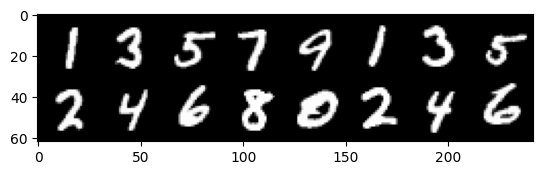

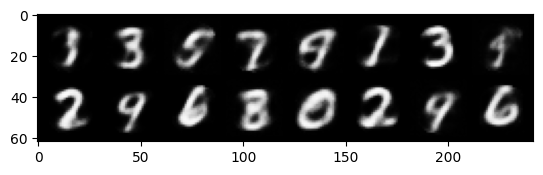

epoch : 2/10, Train loss = 4501.218872
epoch : 2/10, Test loss = 1077.883566


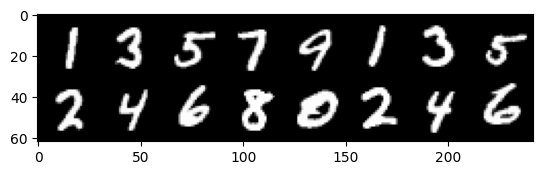

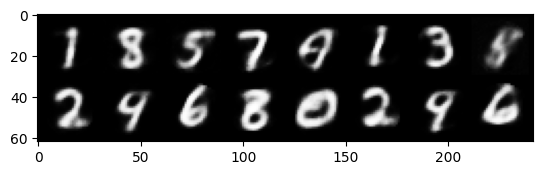

epoch : 3/10, Train loss = 4257.728894
epoch : 3/10, Test loss = 1038.867378


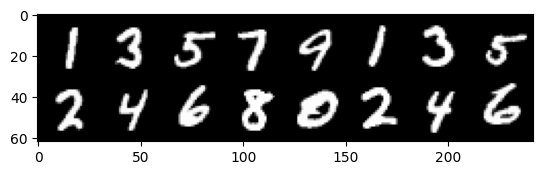

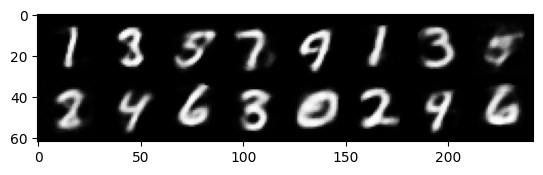

epoch : 4/10, Train loss = 4144.083059
epoch : 4/10, Test loss = 1015.744403


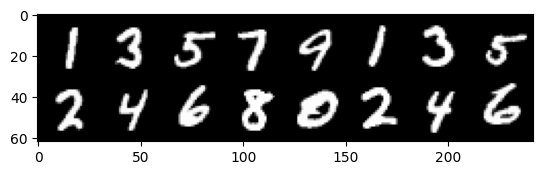

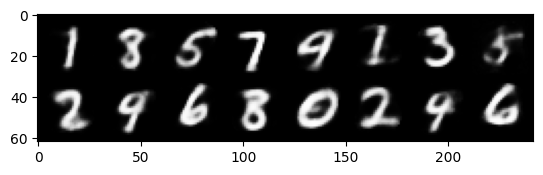

epoch : 5/10, Train loss = 4071.886794
epoch : 5/10, Test loss = 1000.846587


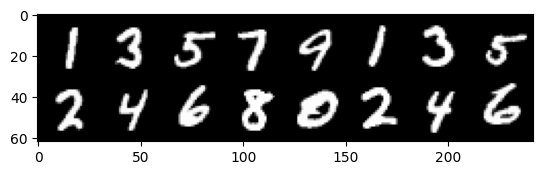

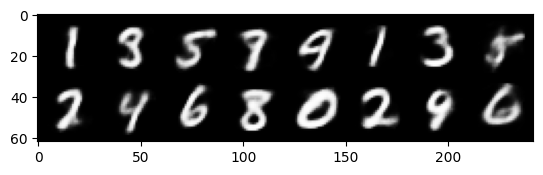

epoch : 6/10, Train loss = 4025.852234
epoch : 6/10, Test loss = 993.487123


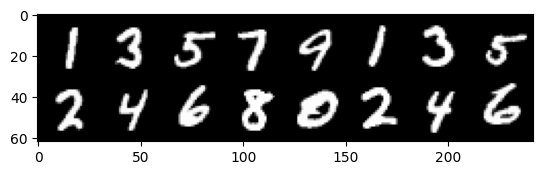

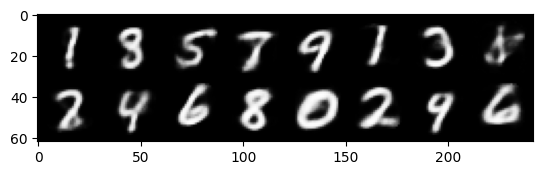

epoch : 7/10, Train loss = 3992.559516
epoch : 7/10, Test loss = 987.052128


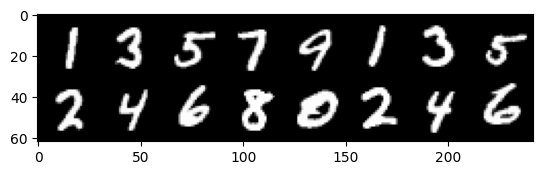

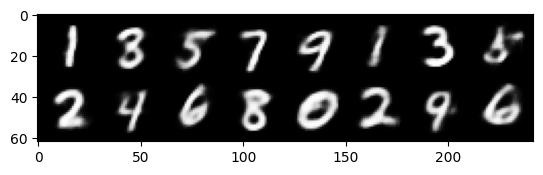

epoch : 8/10, Train loss = 3970.274195
epoch : 8/10, Test loss = 981.754335


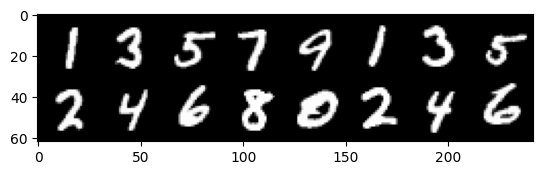

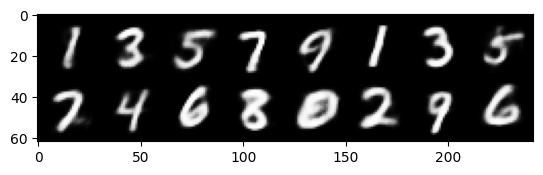

epoch : 9/10, Train loss = 3943.219855
epoch : 9/10, Test loss = 977.366079


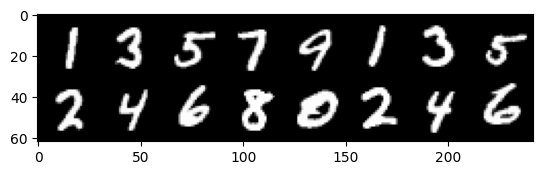

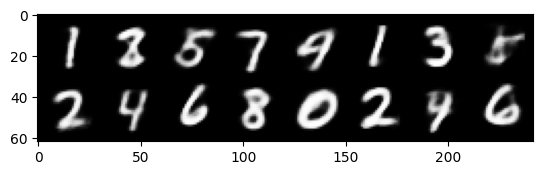

epoch : 10/10, Train loss = 3930.155879
epoch : 10/10, Test loss = 970.827889


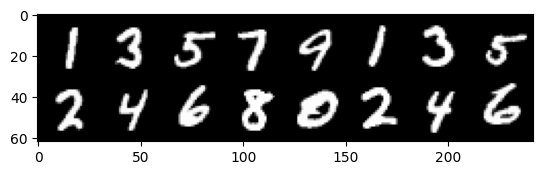

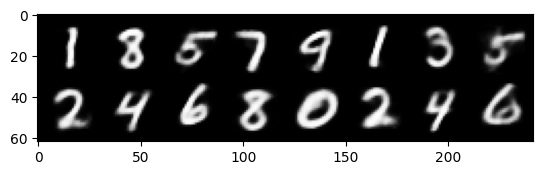

In [58]:
epochs=10
for epoch in range(epochs):
    train_vae(model, train_loader, optimizer, criterion)
    test_vae(model, test_loader, criterion)

We can now use our variational autoencoder to generate new digits. Below we select two digits, and we interpolate between their embeddings to generate embeddings on the line connecting the two original digits. Then we plot them - you should be able to see an evolution from one to the other.

In [59]:
model.eval()

def interpolation(lambda1, model, img1, img2):

    with torch.no_grad():

        # latent vector of first image
        #img1 = img1.view(img1.size(0), -1).to(device)
        img1 = img1.view(-1, 784).to(device)
        latent_1, _ = model.encode(img1)

        # latent vector of second image
        #img2 = img2.view(img2.size(0), -1).to(device)
        img2 = img2.view(-1, 784).to(device)
        latent_2, _ = model.encode(img2)

        # interpolation of the two latent vectors
        inter_latent = (1-lambda1) * latent_1 + lambda1 * latent_2

        # reconstruct interpolated image
        inter_image = model.decode(inter_latent)
        inter_image = inter_image.cpu()

        return inter_image


def visualize_interpolation(model, test_dataloader, digit1 = 7, digit2 = 1):
    # sort part of test set by digit
    digits = [[] for _ in range(10)] # an empty structure to keep samples corresponding to the different digits

    for img_batch, label_batch in test_dataloader:
        for i in range(img_batch.size(0)):
            digits[label_batch[i]].append(img_batch[i:i+1])
        if sum(len(d) for d in digits) >= 1000: # stop when we reach 1000 digits
            break;

    # interpolation lambdas
    lambda_range=np.linspace(0,1,10) # Get 10 points between 0 and 1

    fig, axs = plt.subplots(2,5, figsize=(15, 6))
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()

    for ind,l in enumerate(lambda_range):
        inter_image=interpolation(float(l), model, digits[digit1][0], digits[digit2][0])

        inter_image = inter_image.view(1, 28, 28)

        image = inter_image.numpy()
        axs[ind].imshow(image[0,:,:], cmap='gray')
        axs[ind].set_title('lambda_val='+str(round(l,1)))
    plt.show()

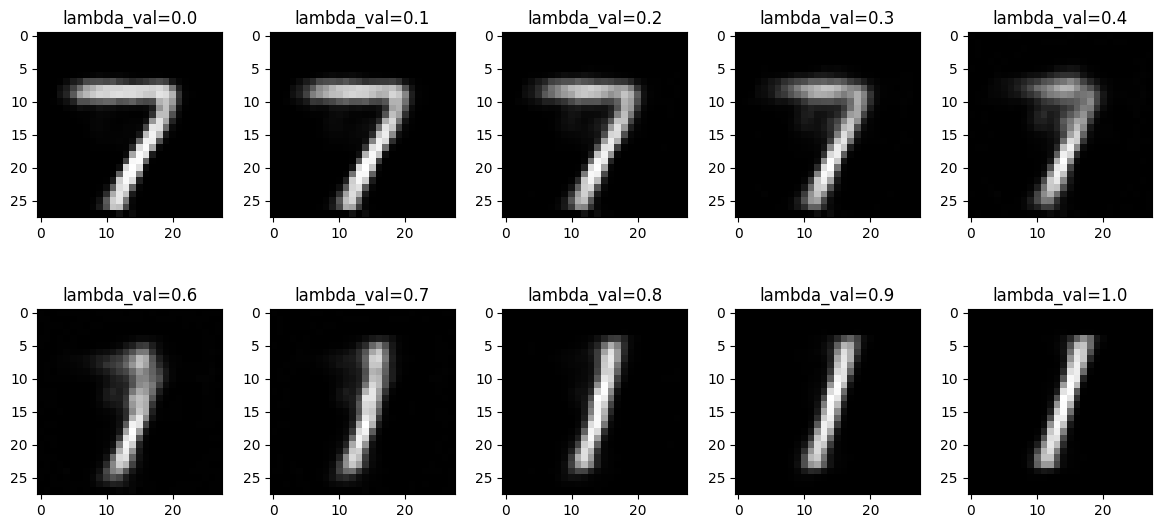

In [60]:
visualize_interpolation(model, test_loader, 7, 1)

<span style="color:blue">

**Exercise 3**: Use the already trained VAE model to generate 100 random new digits.

> Hint: Have a look at PyTorch's `randn()` https://pytorch.org/docs/stable/generated/torch.randn.html
    
</span>

In [61]:
# Your Code Here
"""
We do this by sampling 100 random vectors from a standard normal distribution
(using torch.randn), each of size equal to the latent dimension (20 in our case),
which represents points in the learned latent space of the VAE. These are then
passed through the decoder to generate new digit images.
"""
num_samples = 100
latent_dim = 20
random_latent_vectors = torch.randn(num_samples, latent_dim).to(device)  # Sample from standard normal distribution

with torch.no_grad():
    # Decode the random latent vectors into generated images
    # Use model instead of VAE to call decode() on an instance
    generated_images = model.decode(random_latent_vectors)

# Reshape the generated images to (28, 28) for visualization
generated_images = generated_images.view(num_samples, 28, 28).cpu().numpy()


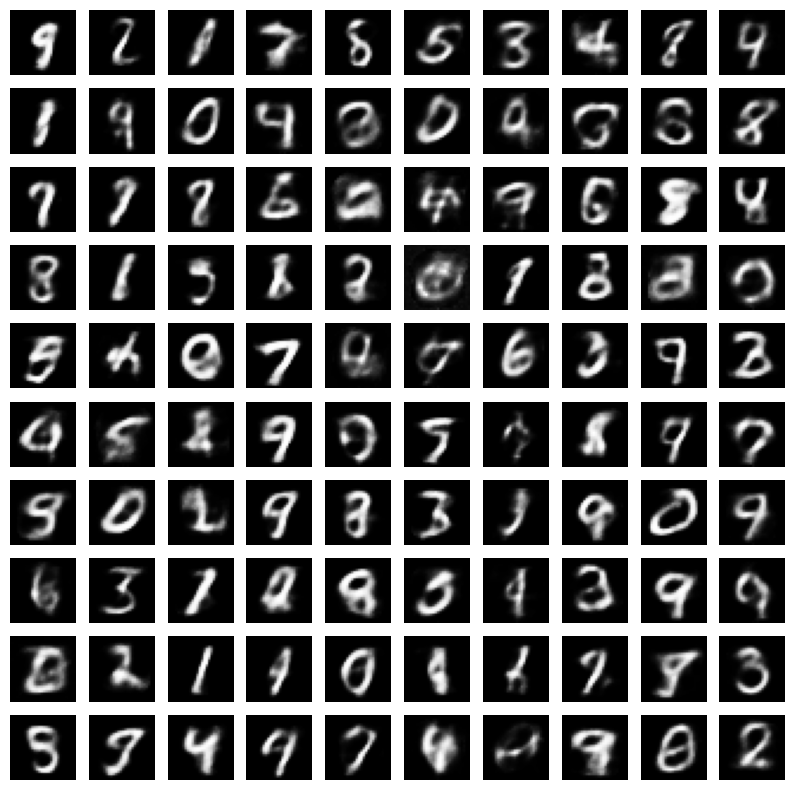

In [62]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(10, 10, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(generated_images[i], cmap= "gray")
    ax.axis("off")

plt.show()

<span style="color:blue">

**Exercise 4**: Modify the VAE model so that it creates a 2-dimensional latent space. Train it on MNIST and then complete the cell below to visualize the entire 2D latent space.
    
</span>

In [63]:
class VAE2D(nn.Module):
    def __init__(self):
        super(VAE2D, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 2) #With this little change it would create a 2d latent space instead of a 20d latent space
        self.fc22 = nn.Linear(400, 2) #With this little change it would create a 2d latent space instead of a 20d latent space

        self.fc3 = nn.Linear(2, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparametrize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        return mu + eps * std

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar

In [64]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

VAE2D = VAE2D().to(device)

# create an optimizer object
optimizer = torch.optim.Adam(VAE2D.parameters(), lr=1e-3)

criterion = loss_function #loss_function = recLoss(recon_x, x) + KLD

epoch : 1/10, Train loss = 6304.588964
epoch : 1/10, Test loss = 1379.622225


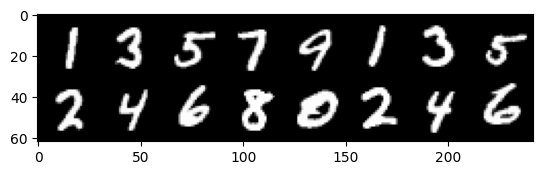

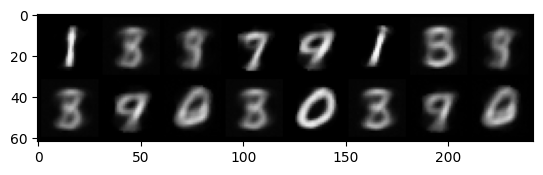

epoch : 2/10, Train loss = 5433.900723
epoch : 2/10, Test loss = 1346.004434


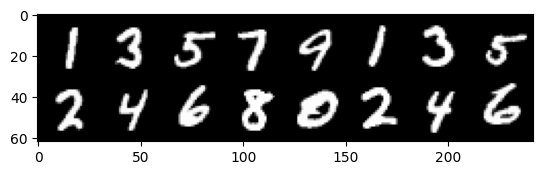

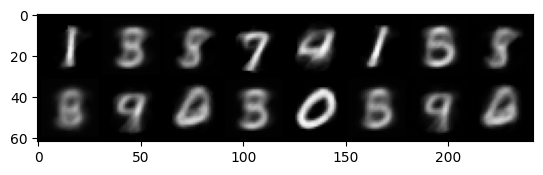

epoch : 3/10, Train loss = 5293.103827
epoch : 3/10, Test loss = 1315.606746


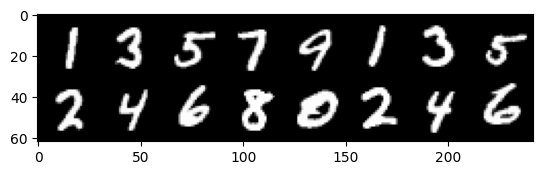

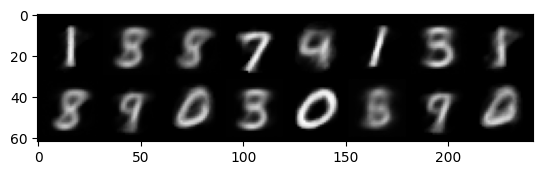

epoch : 4/10, Train loss = 5199.875031
epoch : 4/10, Test loss = 1292.801441


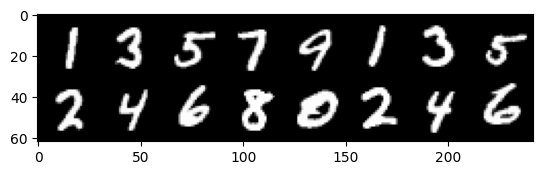

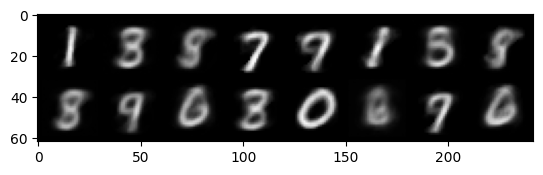

epoch : 5/10, Train loss = 5130.464647
epoch : 5/10, Test loss = 1275.871604


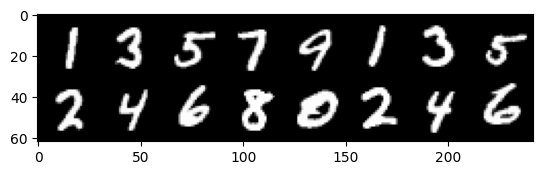

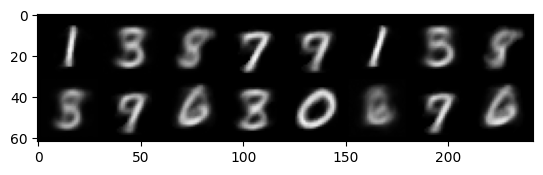

epoch : 6/10, Train loss = 5077.404976
epoch : 6/10, Test loss = 1264.927122


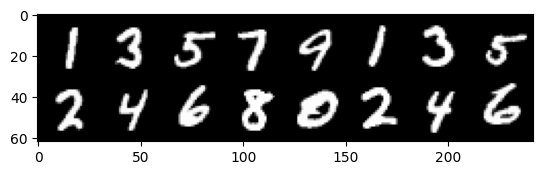

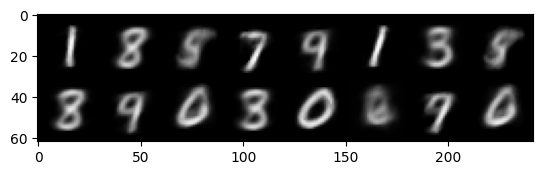

epoch : 7/10, Train loss = 5037.513942
epoch : 7/10, Test loss = 1256.901748


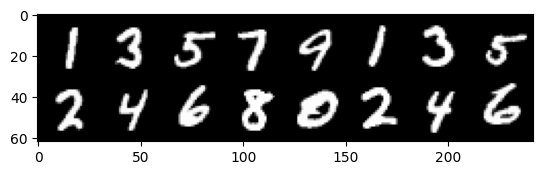

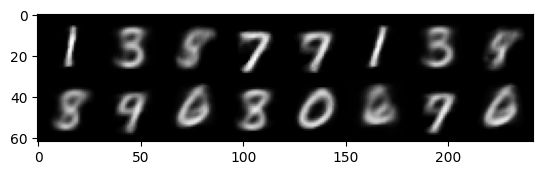

epoch : 8/10, Train loss = 5005.426703
epoch : 8/10, Test loss = 1252.106913


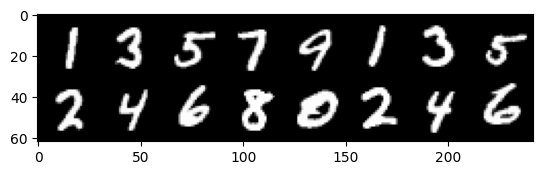

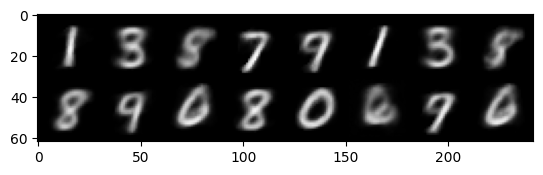

epoch : 9/10, Train loss = 4977.215463
epoch : 9/10, Test loss = 1246.361087


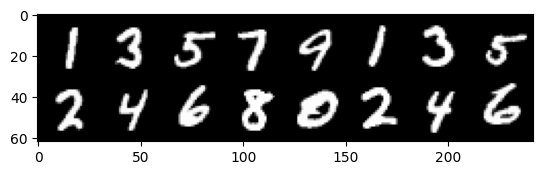

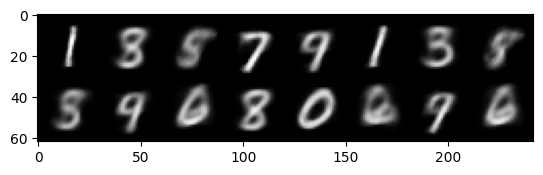

epoch : 10/10, Train loss = 4952.025451
epoch : 10/10, Test loss = 1240.783423


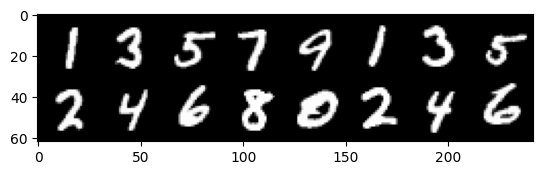

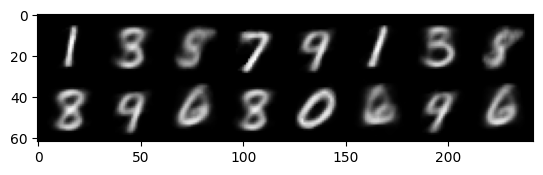

In [65]:
epochs=10
for epoch in range(epochs):
    train_vae(VAE2D, train_loader, optimizer, criterion)
    test_vae(VAE2D, test_loader, criterion)

---
When working with very low-dimensional latent spaces—like 2D—it’s expected that some detail will be lost, which can affect how sharp or realistic the generated digits look.

The goal of using just two dimensions isn’t high-quality generation, but rather to give us a visual way to explore how the model captures and organizes patterns in the data.

---

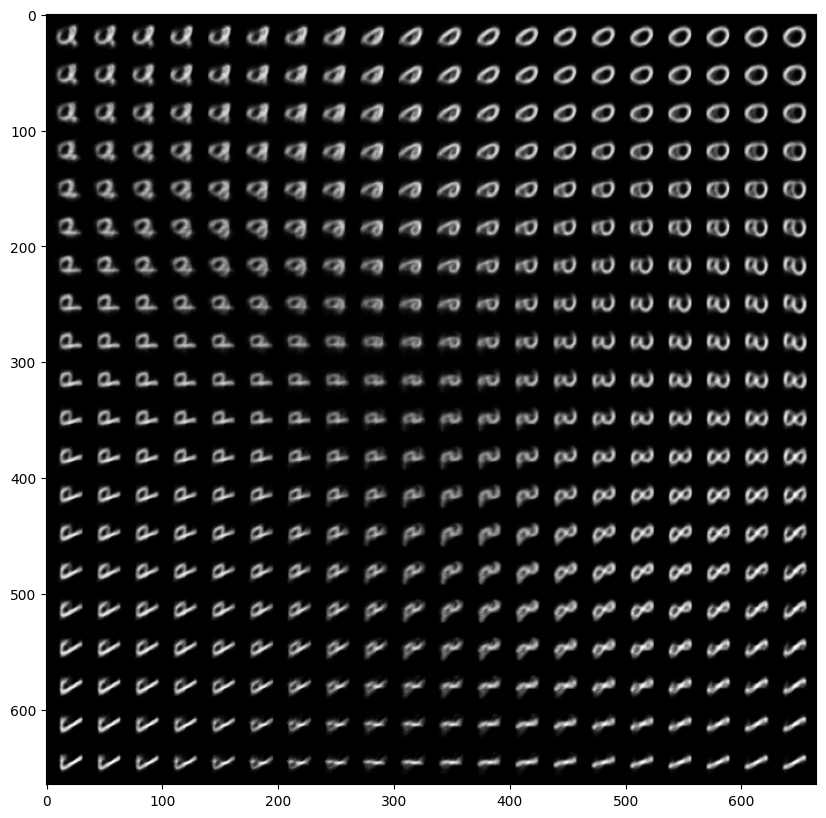

In [66]:
with torch.no_grad():

    # create a sample grid in 2d latent space
    latent_x = np.linspace(-1.5,1.5,20)
    latent_y = np.linspace(-1.5,1.5,20)
    latents = torch.FloatTensor(len(latent_y), len(latent_x), 2)
    for i, lx in enumerate(latent_x):
        for j, ly in enumerate(latent_y):
            latents[j, i, 0] = lx
            latents[j, i, 1] = ly
    latents = latents.view(-1, 2) # flatten grid into a batch

    # reconstruct images from the latent vectors
    # Your code here
    image_recon = VAE2D.decode(latents.to(device)).cpu()

    fig, ax = plt.subplots(figsize=(10, 10))
    show_image(torchvision.utils.make_grid(image_recon.view(-1, 1, 28, 28),20,5))
    plt.show()

<span style="color:blue">

**Exercise 5**: Try both the simple encoder and the convolutional encoder with the FashionMNIST dataset, comment what you observe for both results.
    
</span>

In [67]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset_FMNIST = torchvision.datasets.FashionMNIST(
    root="data", train=True, transform=transform, download=True
)

test_dataset_FMNIST = torchvision.datasets.FashionMNIST(
    root="data", train=False, transform=transform, download=True
)

train_loader_FMNIST = torch.utils.data.DataLoader(
    train_dataset_FMNIST, batch_size=128, shuffle=True, num_workers=2#, pin_memory=True
)

test_loader_FMNIST = torch.utils.data.DataLoader(
    test_dataset_FMNIST, batch_size=32, shuffle=False, num_workers=2
)

### Simple autoencoder

In [68]:
AE = AE(input_size=784).to(device)
# create an optimizer object
optimizer = torch.optim.Adam(AE.parameters(), lr=1e-3)

# mean-squared error loss
criterion = nn.MSELoss()

epoch : 1/10, Train loss = 0.036704
epoch : 1/10, Test loss = 0.021811


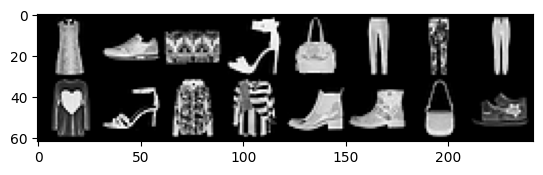

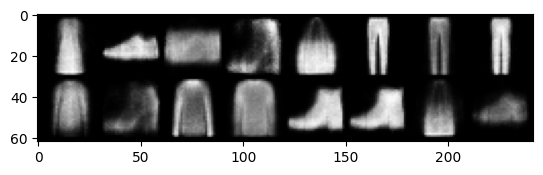

epoch : 2/10, Train loss = 0.019510
epoch : 2/10, Test loss = 0.017949


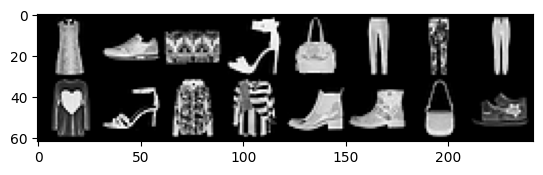

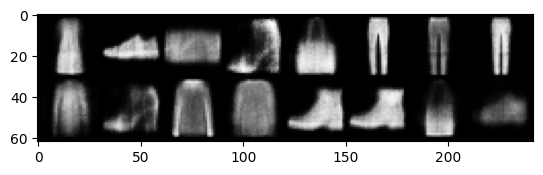

epoch : 3/10, Train loss = 0.016733
epoch : 3/10, Test loss = 0.015714


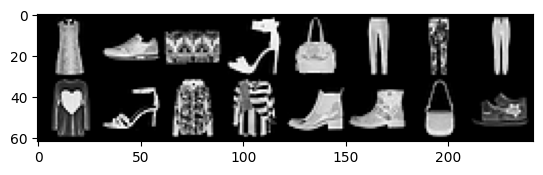

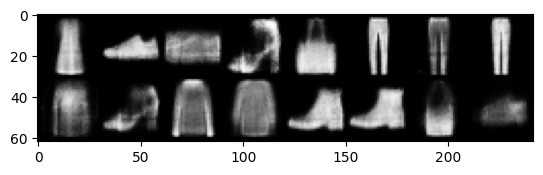

epoch : 4/10, Train loss = 0.015004
epoch : 4/10, Test loss = 0.014401


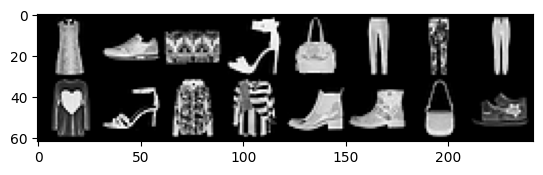

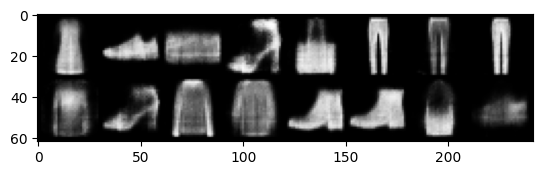

epoch : 5/10, Train loss = 0.013776
epoch : 5/10, Test loss = 0.013367


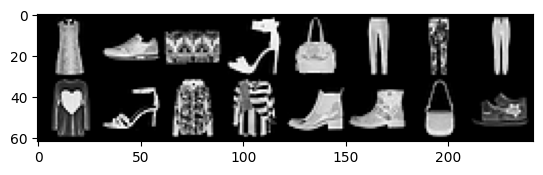

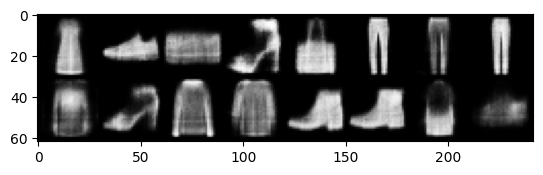

epoch : 6/10, Train loss = 0.012915
epoch : 6/10, Test loss = 0.012692


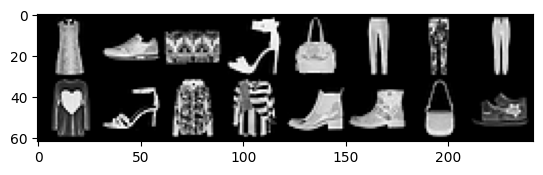

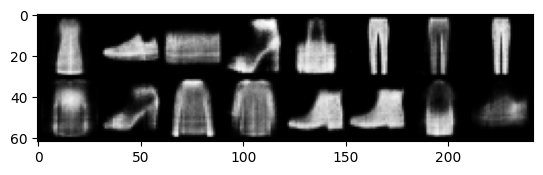

epoch : 7/10, Train loss = 0.012212
epoch : 7/10, Test loss = 0.011979


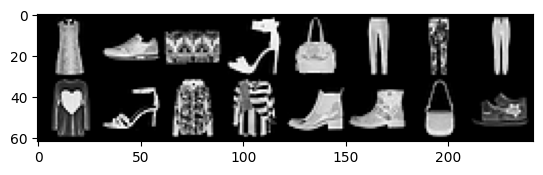

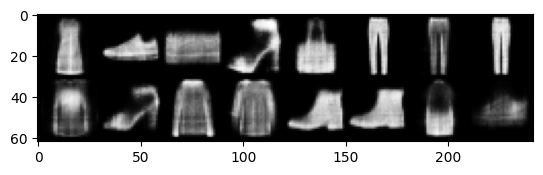

epoch : 8/10, Train loss = 0.011652
epoch : 8/10, Test loss = 0.011539


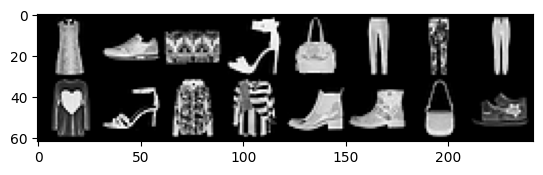

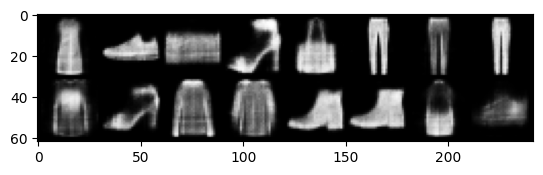

epoch : 9/10, Train loss = 0.011242
epoch : 9/10, Test loss = 0.011162


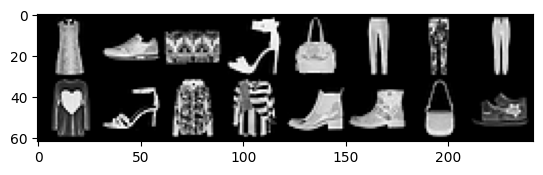

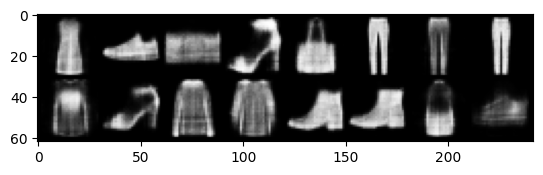

epoch : 10/10, Train loss = 0.010827
epoch : 10/10, Test loss = 0.010798


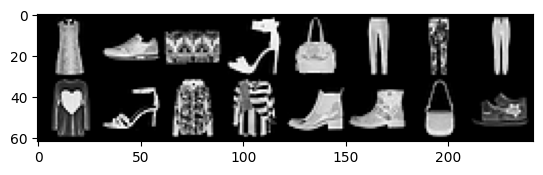

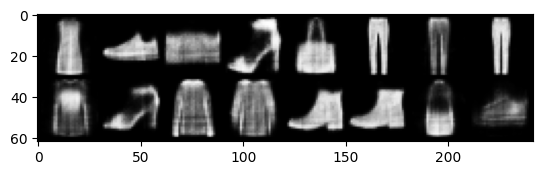

In [69]:
epochs=10
for epoch in range(epochs):
    train(AE, train_loader_FMNIST, optimizer, criterion, reshape=True)
    test(AE, test_loader_FMNIST, criterion, reshape=True)

### Convolutional autoencoder

In [70]:
# create an optimizer object
optimizer = torch.optim.Adam(ConvAE.parameters(), lr=4e-3)

# mean-squared error loss
criterion = nn.MSELoss()

epoch : 1/10, Train loss = 0.032822
epoch : 1/10, Test loss = 0.026612


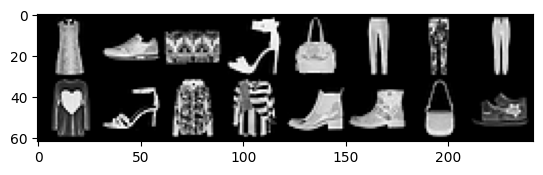

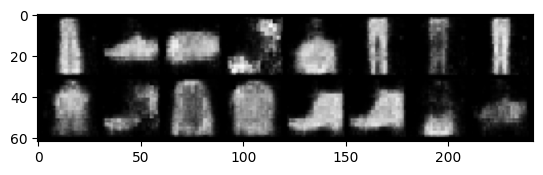

epoch : 2/10, Train loss = 0.025326
epoch : 2/10, Test loss = 0.024571


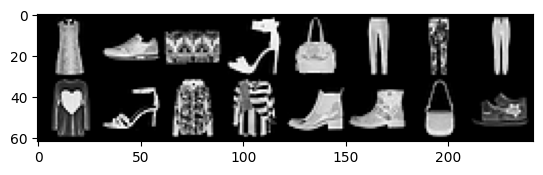

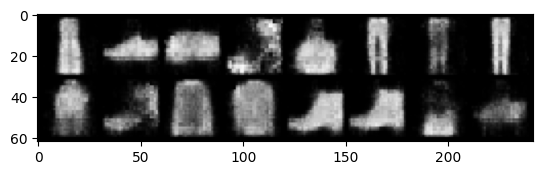

epoch : 3/10, Train loss = 0.023878
epoch : 3/10, Test loss = 0.023487


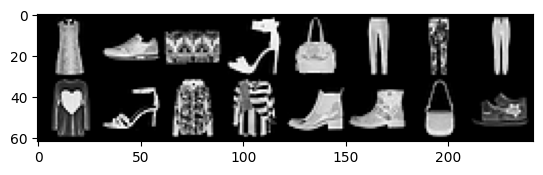

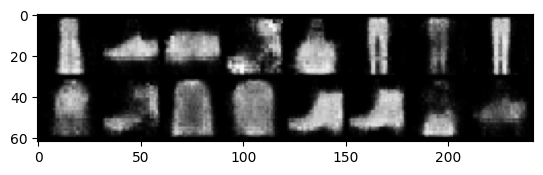

epoch : 4/10, Train loss = 0.023148
epoch : 4/10, Test loss = 0.022927


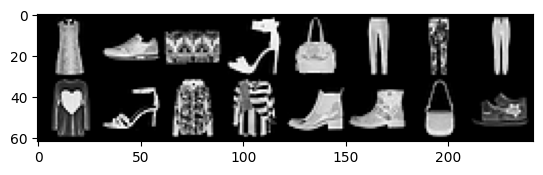

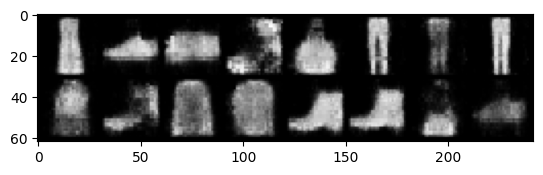

epoch : 5/10, Train loss = 0.022687
epoch : 5/10, Test loss = 0.022772


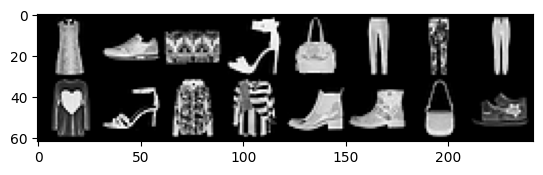

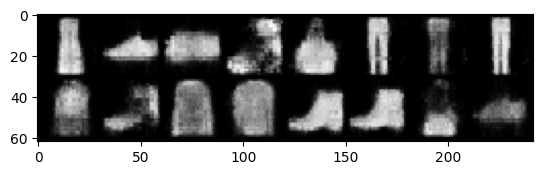

epoch : 6/10, Train loss = 0.022391
epoch : 6/10, Test loss = 0.022402


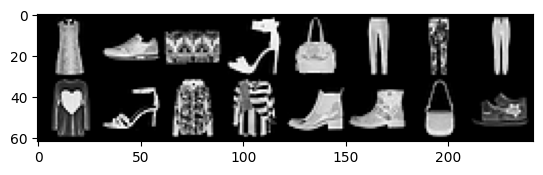

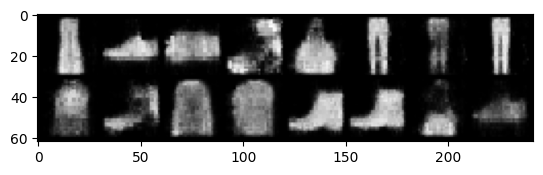

epoch : 7/10, Train loss = 0.022151
epoch : 7/10, Test loss = 0.022135


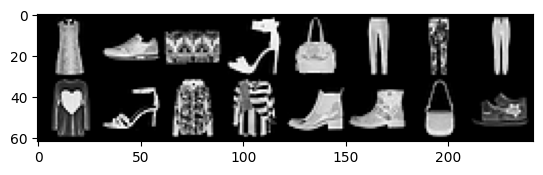

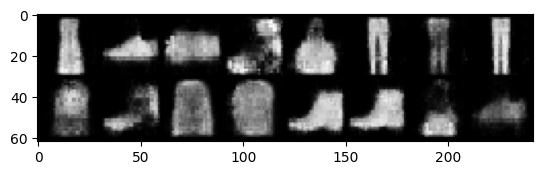

epoch : 8/10, Train loss = 0.021945
epoch : 8/10, Test loss = 0.021965


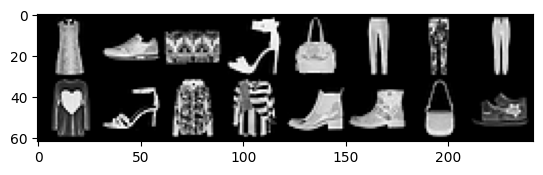

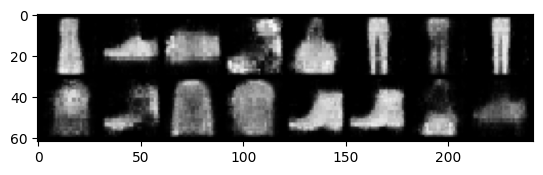

epoch : 9/10, Train loss = 0.021797
epoch : 9/10, Test loss = 0.021826


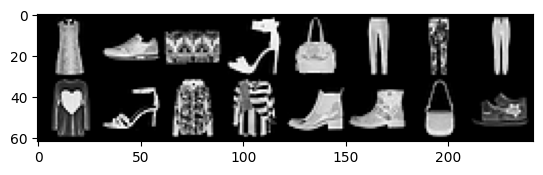

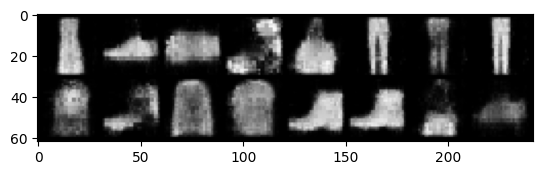

epoch : 10/10, Train loss = 0.021610
epoch : 10/10, Test loss = 0.021603


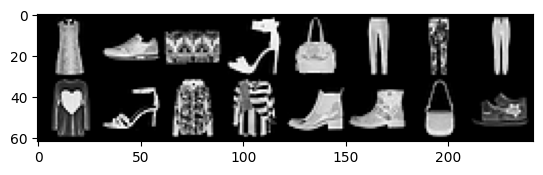

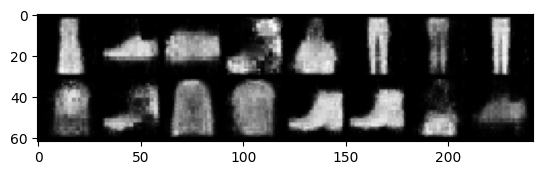

In [71]:
epochs=10
for epoch in range(epochs):
    train(ConvAE, train_loader_FMNIST, optimizer, criterion, reshape=False)
    test(ConvAE, test_loader_FMNIST, criterion, reshape=False)

#### --> Symmetric Convolutional Autoencoder

In [72]:
# create an optimizer object
optimizer = torch.optim.Adam(ConvAE_symmetric.parameters(), lr=4e-3)

# mean-squared error loss
criterion = nn.MSELoss()

epoch : 1/10, Train loss = 0.060139
epoch : 1/10, Test loss = 0.054105


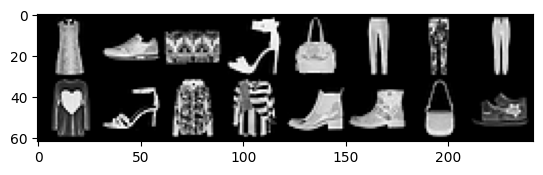

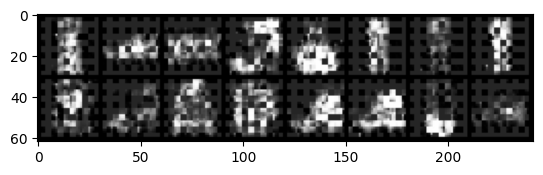

epoch : 2/10, Train loss = 0.054192
epoch : 2/10, Test loss = 0.054465


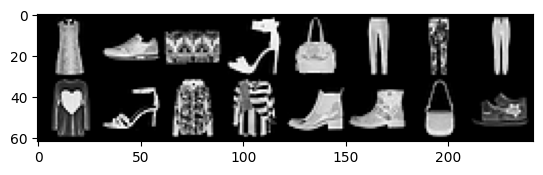

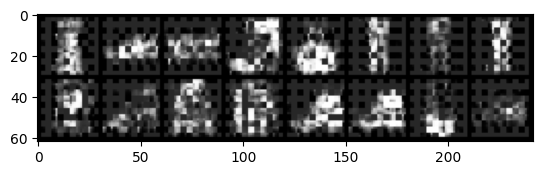

epoch : 3/10, Train loss = 0.054083
epoch : 3/10, Test loss = 0.052190


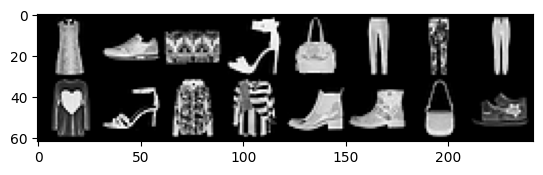

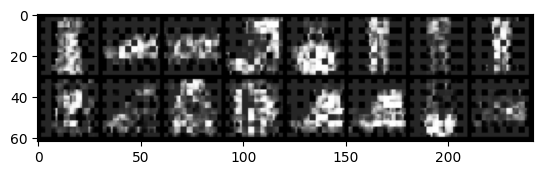

epoch : 4/10, Train loss = 0.051578
epoch : 4/10, Test loss = 0.051715


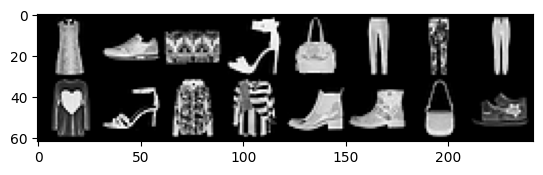

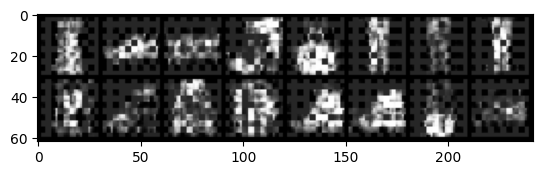

epoch : 5/10, Train loss = 0.051740
epoch : 5/10, Test loss = 0.051596


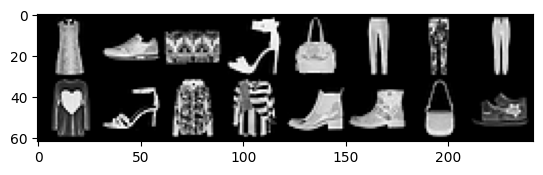

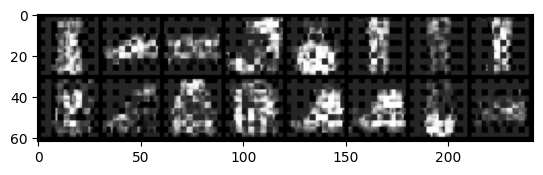

epoch : 6/10, Train loss = 0.051652
epoch : 6/10, Test loss = 0.051374


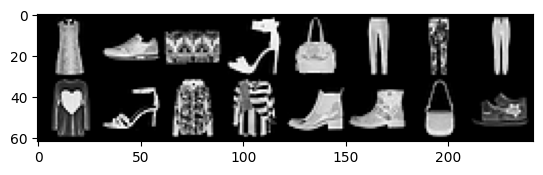

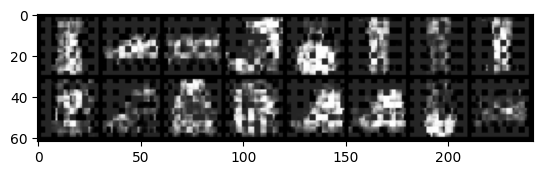

epoch : 7/10, Train loss = 0.051121
epoch : 7/10, Test loss = 0.050900


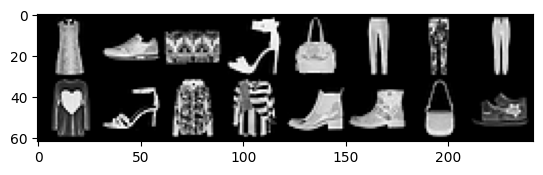

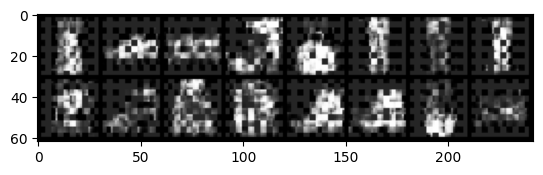

epoch : 8/10, Train loss = 0.050809
epoch : 8/10, Test loss = 0.051362


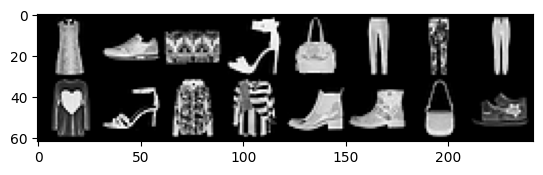

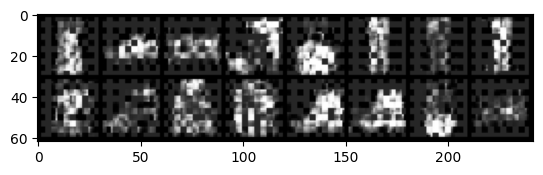

epoch : 9/10, Train loss = 0.051773
epoch : 9/10, Test loss = 0.051833


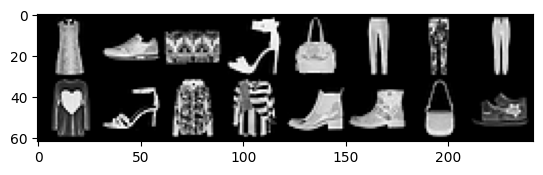

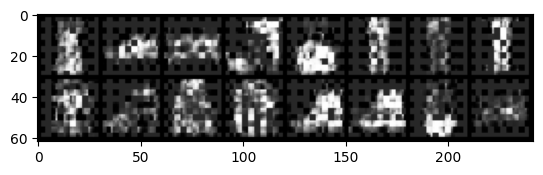

epoch : 10/10, Train loss = 0.051809
epoch : 10/10, Test loss = 0.051607


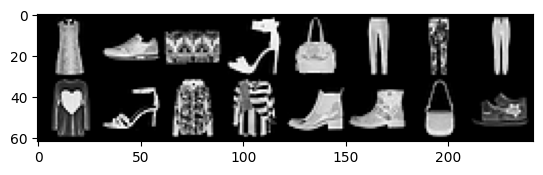

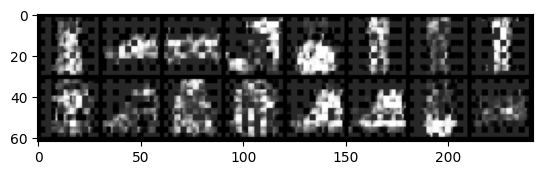

In [73]:
epochs=10
for epoch in range(epochs):
    train(ConvAE_symmetric, train_loader_FMNIST, optimizer, criterion, reshape=False)
    test(ConvAE_symmetric, test_loader_FMNIST, criterion, reshape=False)

---
In this final exercise, we compared the outputs of three different autoencoder architectures: a simple autoencoder, a convolutional autoencoder, and a symmetric convolutional autoencoder. Each model has its strengths and limitations, and observing their reconstructed outputs helped us understand these differences in practice. The simple autoencoder, based on fully connected layers, often struggles to capture spatial features in image data, resulting in blurrier reconstructions. The convolutional autoencoder improved on this by leveraging spatial hierarchies, producing clearer and more structured outputs. Finally, the symmetric convolutional autoencoder, with mirrored encoder-decoder architecture and unpooling layers, preserved more fine-grained details, leading to the best reconstructions among the three. This progression highlights how model design impacts performance, especially for image data where structure and locality matter.


---